In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy
import os

# Adding library directory to python search path
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [2]:
class setup:
    lambda_ = 640e-9     # nano meters
    lambda_err = 20e-9
    F = 28e-2 # m
    mk_screw = 4  # mkm
    y_err = mk_screw
    gap_width = 60 # mkm
    wire_gap_coord = 7.8 # turnovers

    scale_mcscope = 1.2 # mm/seg

In [3]:
data = mipt.read_excel('dat/432.xlsx', usecols=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N'], nrows=6).dropna(how='all')
data

,m,Y,freq,Y.1,freq.1,Y.2,freq.2,Y.3,freq.3,N,x1,x2,freq.4
0,0,204,1.0409,213.0,1.5013,166.0,0.9084,175.0,1.975,9.0,6.8,1.8,1.0499
1,1,174,NaN,158.0,NaN,140.0,NaN,110.0,NaN,11.0,6.9,1.6,1.2356
2,2,145,NaN,113.0,NaN,111.0,NaN,55.0,NaN,16.0,6.9,1.4,1.7328
3,3,112,NaN,67.0,NaN,83.0,NaN,NaN,NaN,19.0,6.5,1.1,2.0150
4,4,81,NaN,45.0,NaN,56.0,NaN,NaN,NaN,14.0,6.7,1.1,1.4802
5,5,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
xsl = {
    "Y" : "y1",
    "freq" : "f1",
    "Y.1" : "y2",
    "freq.1" : "f2",
    "Y.2" : "y3",
    "freq.2" : "f3",
    "Y.3" : "y4",
    "freq.3" : "f4",
    "N" : "n_lines",
    "x1" : "up_line_x",
    "x2" : "bot_line_x",
    "freq.4" : "freqs"
}

data = mipt.map_excel(data, xsl)
data

,m,y1,f1,y2,f2,y3,f3,y4,f4,n_lines,up_line_x,bot_line_x,freqs
0,0,204,1.0409,213.0,1.5013,166.0,0.9084,175.0,1.975,9.0,6.8,1.8,1.0499
1,1,174,NaN,158.0,NaN,140.0,NaN,110.0,NaN,11.0,6.9,1.6,1.2356
2,2,145,NaN,113.0,NaN,111.0,NaN,55.0,NaN,16.0,6.9,1.4,1.7328
3,3,112,NaN,67.0,NaN,83.0,NaN,NaN,NaN,19.0,6.5,1.1,2.0150
4,4,81,NaN,45.0,NaN,56.0,NaN,NaN,NaN,14.0,6.7,1.1,1.4802
5,5,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


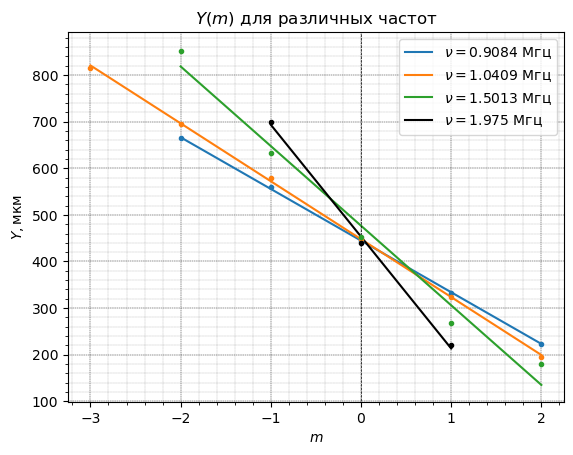

In [5]:
m = data['m'].dropna()
f1 = data['f1'][0]
f2 = data['f2'][0]
f3 = data['f3'][0]
f4 = data['f4'][0]

y1 = data['y1'].dropna()
y1 *= setup.mk_screw
m1 = np.array(m[:len(y1)])
m1 -= int(len(m1)/2)

y2 = data['y2'].dropna()
y2 *= setup.mk_screw
m2 = np.array(m[:len(y2)])
m2 -= int(len(m2)/2)

y3 = data['y3'].dropna()
y3 *= setup.mk_screw
m3 = np.array(m[:len(y3)])
m3 -= int(len(m3)/2)

y4 = data['y4'].dropna()
y4 *= setup.mk_screw
m4 = np.array(m[:len(y4)])
m4 -= int(len(m4)/2)

mipt.plot(m3, y3, yerr=setup.y_err, label=r"$\nu=$"+f"{f3} Мгц")
mipt.plot(m1, y1, yerr=setup.y_err, label=r"$\nu=$"+f"{f1} Мгц")
mipt.plot(m2, y2, yerr=setup.y_err, label=r"$\nu=$"+f"{f2} Мгц")
mipt.plot(m4, y4, yerr=setup.y_err, label=r"$\nu=$"+f"{f4} Мгц", color="black")

plt.ylabel(r"$Y, \text{мкм}$")
plt.xlabel(r"$m$")
plt.axvline(x = 0, ymin = -1, ymax = 100, color = 'black', linestyle = '--', linewidth = 0.5)
plt.minorticks_on()
plt.grid(which = "minor", linewidth = 0.1)
plt.grid(which = "major", linewidth = 0.3)
plt.grid(color = 'black', linestyle = '--', which = "both")
plt.title(r"$Y(m)$ для различных частот")

plt.legend()

plt.savefig('gen/Y_nu.png')
plt.show()

In [6]:
mnk_data = mipt.mnk(m1, y1)
k_1 = mnk_data.get_data()["a"][0]
k_1_err = mnk_data.get_data()["da"][0]
print("k_1, k_1_err", k_1, k_1_err)

mnk_data = mipt.mnk(m2, y2)
k_2 = mnk_data.get_data()["a"][0]
k_2_err = mnk_data.get_data()["da"][0]
print("k_2, k_2_err", k_2, k_2_err)

mnk_data = mipt.mnk(m3, y3)
k_3 = mnk_data.get_data()["a"][0]
k_3_err = mnk_data.get_data()["da"][0]
print("k_3, k_3_err", k_3, k_3_err)

mnk_data = mipt.mnk(m4, y4)
k_4 = mnk_data.get_data()["a"][0]
k_4_err = mnk_data.get_data()["da"][0]
print("k_4, k_4_err", k_4, k_4_err)


k_1, k_1_err -124.22857142857144 1.1654901745353299
k_2, k_2_err -170.8 13.464026143765379
k_3, k_3_err -110.8 1.006644591368373
k_4, k_4_err -240.0 11.547005383793566


$$l_m = mF\lambda / \Lambda$$
$$\Lambda = mF\lambda / l_m$$
$$v = \Lambda \nu$$

$$\sigma_\Lambda = \Lambda \sqrt{(\frac{\Delta \lambda}{\lambda})^2 + (\frac{\Delta Y \cdot 2}{l_m})^2}$$

In [7]:
zero_y_ind = np.where(m1 == 0)[0]

Lambda1 = -m1[0]*setup.F * setup.lambda_ / (y1[0]-y1[zero_y_ind[0]]) * 10**6
Lambda1_err = Lambda1 * np.sqrt((setup.lambda_err/setup.lambda_)**2 + (setup.mk_screw*2/(y1[0]-y1[zero_y_ind[0]]))**2)

zero_y_ind = np.where(m2 == 0)[0]
Lambda2 = -m2[0]*setup.F * setup.lambda_ / (y2[0]-y2[zero_y_ind[0]]) * 10**6
Lambda2_err = Lambda2 * np.sqrt((setup.lambda_err/setup.lambda_)**2 + (setup.mk_screw*2/(y2[0]-y2[zero_y_ind[0]]))**2)

zero_y_ind = np.where(m3 == 0)[0]
Lambda3 = -m3[0]*setup.F * setup.lambda_ / (y3[0]-y3[zero_y_ind[0]]) * 10**6
Lambda3_err = Lambda3 * np.sqrt((setup.lambda_err/setup.lambda_)**2 + (setup.mk_screw*2/(y3[0]-y3[zero_y_ind[0]]))**2)


zero_y_ind = np.where(m4 == 0)[0]
Lambda4 = -m4[0]*setup.F * setup.lambda_ / (y4[0]-y4[zero_y_ind[0]]) * 10**6
Lambda4_err = Lambda4 * np.sqrt((setup.lambda_err/setup.lambda_)**2 + (setup.mk_screw*2/(y4[0]-y4[zero_y_ind[0]]))**2)

print(f"Lambda1 = {Lambda1} +- {Lambda1_err}, e={Lambda1_err/Lambda1 * 100}%")
print(f"Lambda2 = {Lambda2} +- {Lambda2_err}, e={Lambda2_err/Lambda2 * 100}%")
print(f"Lambda3 = {Lambda3} +- {Lambda3_err}, e={Lambda3_err/Lambda3 * 100}%")
print(f"Lambda4 = {Lambda4} +- {Lambda4_err}, e={Lambda4_err/Lambda4 * 100}%")

Lambda1 = 0.0014608695652173916 +- 5.561199248555009e-05, e=3.806773295141821%
Lambda2 = 0.0008960000000000001 +- 3.3243441458429064e-05, e=3.7102055199139574%
Lambda3 = 0.0016290909090909092 +- 7.810937184715556e-05, e=4.79466010222495%
Lambda4 = 0.0006892307692307693 +- 3.0226585003121796e-05, e=4.3855536276850815%


In [12]:
v1 = Lambda1 * f1 * 10**6
v1_err = v1 * Lambda1_err / Lambda1
v2 = Lambda2 * f2 * 10**6
v2_err = v2 * Lambda2_err / Lambda2
v3 = Lambda3 * f3 * 10**6
v3_err = v3 * Lambda3_err / Lambda3
v4 = Lambda4 * f4 * 10**6
v4_err = v4 * Lambda4_err / Lambda4

avr_v = (v1 + v2 + v3 + v4)/4

print(f"v1 = {v1} +- {v1_err}, freq={f1} Мгц, e={v1_err/v1 * 100}%")
print(f"v2 = {v2} +- {v2_err}, freq={f2} Мгц, e={v2_err/v2 * 100}%")
print(f"v3 = {v3} +- {v3_err}, freq={f3} Мгц, e={v3_err/v3 * 100}%")
print(f"v4 = {v4} +- {v4_err}, freq={f4} Мгц, e={v4_err/v4 * 100}%")

avr_v_err = np.sqrt(((v1-avr_v)**2 + (v1-avr_v)**2 + (v1-avr_v)**2 + (v1-avr_v)**2)/(4*(4-1)))
print(f"<v> = {avr_v} +- {avr_v_err}")

v1 = 1520.6191304347826 +- 57.88652297820908, freq=1.0409 Мгц, e=3.806773295141821%
v2 = 1345.1648000000002 +- 49.90837866153956, freq=1.5013 Мгц, e=3.7102055199139574%
v3 = 1479.8661818181818 +- 70.9545533859561, freq=0.9084 Мгц, e=4.794660102224951%
v4 = 1361.2307692307695 +- 59.697505381165556, freq=1.975 Мгц, e=4.385553627685082%
<v> = 1426.7202203709335 +- 54.21256100197576


## Second part


In [9]:
n_lines = data["n_lines"].dropna()
x1 = data["up_line_x"].dropna() * setup.scale_mcscope
x2 = data["bot_line_x"].dropna() * setup.scale_mcscope
freqs = data["freqs"].dropna()

Lambda = ((x1-x2)/n_lines)*2


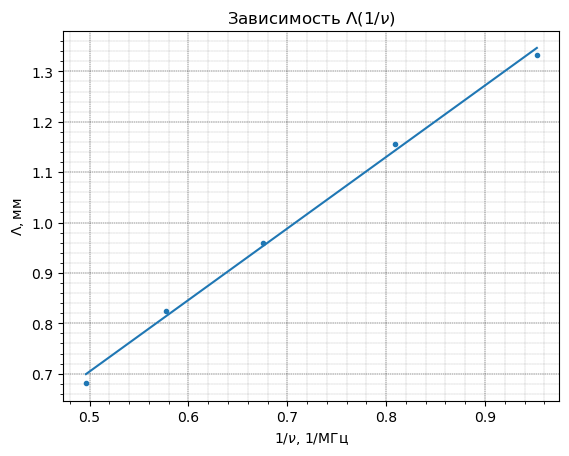

In [10]:
mipt.plot(1/freqs, Lambda, yerr=2*setup.scale_mcscope*0.001, label=r"$\nu=$"+f"{f3} Мгц")

plt.ylabel(r"$\Lambda, \text{мм}$")
plt.xlabel(r"$1/\nu$, 1/МГц")
# plt.axvline(x = 0, ymin = -1, ymax = 100, color = 'black', linestyle = '--', linewidth = 0.5)
plt.minorticks_on()
plt.grid(which = "minor", linewidth = 0.1)
plt.grid(which = "major", linewidth = 0.3)
plt.grid(color = 'black', linestyle = '--', which = "both")
plt.title(r"Зависимость $\Lambda(1/\nu)$")

# plt.legend()

plt.savefig('gen/Lambda_nu.png')
plt.show()

In [11]:
mnk_data = mipt.mnk(1/freqs, Lambda)
sound_speed = mnk_data.get_data()["a"][0]
sound_speed_err = mnk_data.get_data()["da"][0]
print("sound_speed, sound_speed_err in m/s", sound_speed*1000, sound_speed_err*1000)

sound_speed, sound_speed_err in m/s 1419.324503294672 44.752397821513966
